In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
image = cv2.imread('dataset/base/train/St_Wf_D_L__033.JPG', cv2.IMREAD_GRAYSCALE)

# Calculate the mean
mean_value = np.mean(image)

In [3]:
mean_value

np.float64(118.37246041666667)

In [4]:
image.shape

(800, 600)

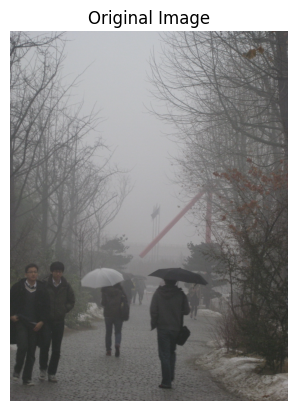

In [14]:
image = cv2.imread('dataset/base/train/St_Wf_D_L__033.JPG', cv2.IMREAD_UNCHANGED)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')
plt.show()

In [5]:
def compute_cap_transmission(image, omega=0.95):
    image = image.astype(np.float32) / 255.0
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    brightness = hsv[:, :, 2]
    saturation = hsv[:, :, 1]
    beta = np.max(brightness)
    transmission = 1 - omega * (beta - saturation)
    transmission = np.clip(transmission, 0, 1)
    return transmission
transmission = compute_cap_transmission(image)

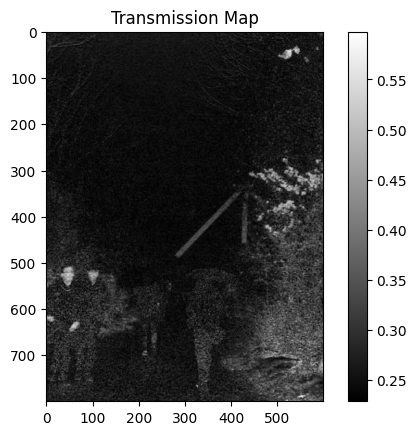

In [ ]:
plt.imshow(transmission, cmap='gray')
plt.title('Transmission Map')
plt.colorbar()
plt.show()

In [16]:
def compute_cap_transmission(image, omega=0.95):
    """
    Computes the transmission map using Color Attenuation Prior (CAP).
    
    Args:
        image (numpy array): Input hazy image (BGR format).
        omega (float): Strength factor for haze removal.

    Returns:
        transmission (numpy array): Estimated transmission map (0-1 range).
    """
    image = image.astype(np.float32) / 255.0
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    brightness = hsv[:, :, 2]  # V channel (brightness)
    saturation = hsv[:, :, 1]  # S channel (saturation)
    
    beta = np.max(brightness) + 1e-5  # Avoid division issues
    transmission = 1 - omega * (beta - saturation)
    transmission = np.clip(transmission, 0, 1)
    
    return transmission

# Test Visualization
transmission = compute_cap_transmission(image)

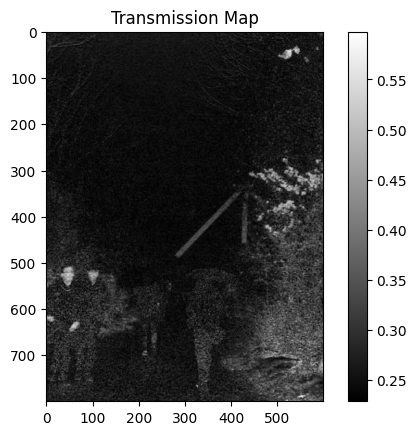

In [18]:
plt.imshow(transmission, cmap='gray')
plt.title('Transmission Map')
plt.colorbar()
plt.show()

In [ ]:
def compute_dcp_transmission(image, omega=0.95, patch_size=15):
    """
    Computes the transmission map using Dark Channel Prior (DCP).
    
    Args:
        image (numpy array): Input hazy image (BGR format).
        omega (float): Strength factor for haze removal.
        patch_size (int): Kernel size for erosion operation.

    Returns:
        transmission (numpy array): Estimated transmission map (0-1 range).
    """
    image = image.astype(np.float32) / 255.0
    min_channel = np.min(image, axis=2)  # Take minimum across R,G,B channels
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (patch_size, patch_size))
    dark_channel = cv2.erode(min_channel, kernel)
    
    transmission = 1 - omega * dark_channel
    transmission = np.clip(transmission, 0, 1)
    
    return transmission

# Test Visualization
transmission = compute_dcp_transmission(image)


In [ ]:
def compute_bcp_transmission(image, omega=0.95):
    """
    Computes the transmission map using Brightness Consistency Prior (BCP).
    
    Args:
        image (numpy array): Input hazy image (BGR format).
        omega (float): Strength factor for haze removal.

    Returns:
        transmission (numpy array): Estimated transmission map (0-1 range).
    """
    image = image.astype(np.float32) / 255.0
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    
    beta = np.max(gray) + 1e-5  # Avoid division issues
    transmission = 1 - omega * (beta - gray)
    transmission = np.clip(transmission, 0, 1)
    
    return transmission

# Test Visualization
transmission = compute_bcp_transmission(image)


In [ ]:
def compute_haze_line_transmission(image, omega=0.95):
    """
    Computes the transmission map using the Haze-Line Prior.
    
    Args:
        image (numpy array): Input hazy image (BGR format).
        omega (float): Strength factor for haze removal.

    Returns:
        transmission (numpy array): Estimated transmission map (0-1 range).
    """
    image = image.astype(np.float32) / 255.0
    mean_intensity = np.mean(image, axis=2)  # Compute mean intensity across RGB channels
    
    beta = np.max(mean_intensity) + 1e-5
    transmission = 1 - omega * (beta - mean_intensity)
    transmission = np.clip(transmission, 0, 1)
    
    return transmission

# Test Visualization
transmission = compute_haze_line_transmission(image)


In [ ]:
def compute_color_line_transmission(image, omega=0.95):
    """
    Computes the transmission map using the Color-Line Prior.
    
    Args:
        image (numpy array): Input hazy image (BGR format).
        omega (float): Strength factor for haze removal.

    Returns:
        transmission (numpy array): Estimated transmission map (0-1 range).
    """
    image = image.astype(np.float32) / 255.0
    std_dev = np.std(image, axis=2)  # Compute standard deviation across RGB channels
    
    beta = np.max(std_dev) + 1e-5
    transmission = 1 - omega * (beta - std_dev)
    transmission = np.clip(transmission, 0, 1)
    
    return transmission

# Test Visualization
transmission = compute_color_line_transmission(image)


In [ ]:
def compute_mcp_transmission(image, omega=0.95):
    """
    Computes the transmission map using the Maximum Channel Prior (MCP).
    
    Args:
        image (numpy array): Input hazy image (BGR format).
        omega (float): Strength factor for haze removal.

    Returns:
        transmission (numpy array): Estimated transmission map (0-1 range).
    """
    image = image.astype(np.float32) / 255.0
    max_channel = np.max(image, axis=2)  # Take maximum across R,G,B channels
    
    beta = np.max(max_channel) + 1e-5
    transmission = 1 - omega * (beta - max_channel)
    transmission = np.clip(transmission, 0, 1)
    
    return transmission

# Test Visualization
transmission = compute_mcp_transmission(image)


In [7]:
# cv2.imshow("Hazy Image", image)
# cv2.imshow("Transmission Map", (transmission * 255).astype(np.uint8))  # Scale for visualization


In [8]:
import torch
import torch.nn as nn

In [9]:


class AdaptiveInstanceNorm(nn.Module):
    def __init__(self, n):
        super(AdaptiveInstanceNorm, self).__init__()

        self.w_0 = nn.Parameter(torch.Tensor([1.0]))
        self.w_1 = nn.Parameter(torch.Tensor([0.0]))

        self.ins_norm = nn.InstanceNorm2d(n, momentum=0.999, eps=0.001, affine=True)

    def forward(self, x):
        return self.w_0 * x + self.w_1 * self.ins_norm(x)


class PALayer(nn.Module):
    def __init__(self, channel: int):
        super(PALayer, self).__init__()
        self.pa = nn.Sequential(
            nn.Conv2d(channel, channel // 8, 1, padding=0, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(channel // 8, 1, 1, padding=0, bias=True),
            nn.Sigmoid(),
        )

    def forward(self, x):
        y = self.pa(x)
        return x * y


class CALayer(nn.Module):
    def __init__(self, channel: int):
        super(CALayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.ca = nn.Sequential(
            nn.Conv2d(channel, channel // 8, 1, padding=0, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(channel // 8, channel, 1, padding=0, bias=True),
            nn.Sigmoid(),
        )

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.ca(y)
        return x * y

In [10]:
class RDB(nn.Module):
    def __init__(self, in_channels, num_dense_layer, growth_rate):
        super(RDB, self).__init__()
        
        modules = []
        self.split_channel=in_channels//4
        kernel_size=3
        dilation=1
        self.conv1 = nn.Conv2d(self.split_channel*1, self.split_channel, kernel_size=kernel_size, padding=dilation, dilation=dilation)
        dilation=2
        self.conv2 = nn.Conv2d(self.split_channel*2, self.split_channel, kernel_size=kernel_size, padding=dilation, dilation=dilation)
        dilation=4
        self.conv3 = nn.Conv2d(self.split_channel*3, self.split_channel, kernel_size=kernel_size,  padding=dilation, dilation=dilation)
        dilation=8
        self.conv4 = nn.Conv2d(self.split_channel*4, self.split_channel, kernel_size=kernel_size, padding=dilation, dilation=dilation)

            
        #self.residual_dense_layers = nn.Sequential(*modules)
        _in_channels=in_channels
        self.calayer=CALayer(in_channels)
        self.palayer=PALayer(in_channels)
        self.conv_1x1 = nn.Conv2d(_in_channels, in_channels, kernel_size=1, padding=0)

    def forward(self, x):
        splited = torch.split(x, self.split_channel, dim=1)
        x0=F.relu(self.conv1(splited[0]))
        tmp= torch.cat((splited[1], x0), 1)
        x1=F.relu(self.conv2(tmp))
        tmp= torch.cat((splited[2], x0, x1), 1)
        x2=F.relu(self.conv3(tmp))
        tmp= torch.cat((splited[3], x0, x1, x2), 1)
        x3=F.relu(self.conv4(tmp))
        tmp= torch.cat(( x0, x1, x2, x3), 1)
        
        out = self.conv_1x1(tmp)
        out=self.calayer(out)
        out=self.palayer(out)
        #print(out.shape, x.shape)
        out=out+x
        return out

In [11]:
import torch.nn.functional as F

# Define the input tensor
input_tensor = torch.randn(1, 64, 128, 128)  # Example input tensor with shape (batch_size, channels, height, width)

# Create an instance of the RDB class
rdb = RDB(in_channels=64, num_dense_layer=4, growth_rate=32)

# Pass the input tensor through the RDB instance
output_tensor = rdb(input_tensor)

# Print the output tensor shape
print(output_tensor.shape)

torch.Size([1, 64, 128, 128])
